# **Style Transfer Re-Producing**

## **라이브러리 임포트 및 데이터 다운로드**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [5]:
!unzip StyleBench.zip

Archive:  StyleBench.zip
   creating: content/
 extracting: content/A beach with a natural rock arch.png  
 extracting: content/A beautiful young woman.png  
  inflating: content/A butterfly.png  
  inflating: content/A car in front of the cottage.png  
  inflating: content/A cow with mountains behind it.png  
 extracting: content/A cute boy.png  
  inflating: content/A helmet displayed on a wooden stand.png  
 extracting: content/A honey jar and an orange.png  
  inflating: content/A lion's head.png  
 extracting: content/A motorcycle.png  
 extracting: content/A small house.png  
  inflating: content/A tree in the middle of the desert.png  
  inflating: content/A vibrant sports car.png  
  inflating: content/A watch.png     
  inflating: content/A wolf.png      
 extracting: content/Alley after rain.png  
  inflating: content/An ancient Chinese bronze ding vessel with intricate patterns and motifs.png  
  inflating: content/Ancient City Wall.png  
  inflating: content/Bust sculpture 

In [28]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # 이미지 resize
    transforms.ToTensor()])  # 텐서 변환


def image_loader(image_name, size=(512, 512)):
    image = Image.open(image_name).convert("RGB")
    image = loader(image)
    image = transforms.functional.resize(image, size)
    image = image.unsqueeze(0) # 입력 차원 맞추기 위해 배치 차원 추가
    return image.to(device, torch.float)

style_content_pairs = [
    ("./style/Abstract/00.jpg", "./content/A cute boy.png"),
    ("./style/Folk art/01.jpg", "./content/A beautiful young woman.png"),
    ("./style/Graffiti/01.jpg", "./content/A wolf.png")
]

style_images = [image_loader(style) for style, content in style_content_pairs]
content_images = [image_loader(content) for style, content in style_content_pairs]

In [29]:
# W 크기가 style_img와 content_img가 달라 크기를 맞춰줌
print(style_images[0].shape)   # 예상 값: torch.Size([1, 3, H, W])
print(content_images[0].shape) # 예상 값: torch.Size([1, 3, H, W])

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [8]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

## **Loss**
- **Content Loss**: 주어진 이미지에 대해 신경망이 추출한 특징 벡터(feature vector)를 사용하여, 해당 특징을 가진 새로운 이미지를 생성

- **Style Loss**: 주어진 이미지에 대해 신경망을 거친 feature map의 gram matrix를 사용하여 texture를 학습

- **Gram Matrix**: 같은 위치에 대해 다른 특징들이 얼마나 상관관계를 띠며 나타나는가

- **Gram matrix**는 공간적 정보가 제거되고 외적을 통해 **feature map 간의 상호작용을 나타내기** 때문에, 어떤 패턴들이 함께 나타나는지를 알 수 있음

In [9]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # detach를 통해 input과 target의 mse를 계산할 때 gradient를 흐르는 것을 방지
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [10]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [11]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # detach를 통해 input과 target의 mse를 계산할 때 gradient를 흐르는 것을 방지
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [12]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 145MB/s] 


In [13]:
# 입력 이미지 정규화
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [14]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        # VGG19 계층을 하나씩 추가하면서 ContentLoss와 StyleLoss 삽입
        # default_layers에서 설정한 계층에 해당될 때마다, loss를 계산
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # VGG19의 마지막 계층까지 계산할 필요가 없음 (손실을 계산하는 층까지만 유지하여 연산량 줄임)
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [15]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

## **학습 및 실행 결과 저장**

In [16]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True) # input_img를 최적화 대상으로 지정

    # model을 업데이트 하지 않도록 함
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 이미지 값을 0~1 범위로 제한하여 RGB이 올바르게 유지될 수 있도록 함
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            # style loss 및 content loss 계산
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss


            # style_weight=1,000,000, content_weight=1이므로 스타일 손실이 더 크게 반영됨
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


### Processing Pair 1 ###

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 53.213436 Content Loss: 13.526581

run [100]:
Style Loss : 19.351273 Content Loss: 13.464248

run [150]:
Style Loss : 9.210479 Content Loss: 13.069569

run [200]:
Style Loss : 4.973601 Content Loss: 12.690982

run [250]:
Style Loss : 3.864792 Content Loss: 12.177637

run [300]:
Style Loss : 3.048878 Content Loss: 11.813009


### Processing Pair 2 ###

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 423.295044 Content Loss: 37.225555

run [100]:
Style Loss : 129.578156 Content Loss: 38.498734

run [150]:
Style Loss : 54.980576 Content Loss: 38.931602

run [200]:
Style Loss : 31.000662 Content Loss: 38.825287

run [250]:
Style Loss : 20.751631 Content Loss: 38.445625

run [300]:
Style Loss : 15.240830 Content Loss: 37.918640


### Processing Pair 3 ###

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 877.319336 Content Loss: 32.457005

run [1

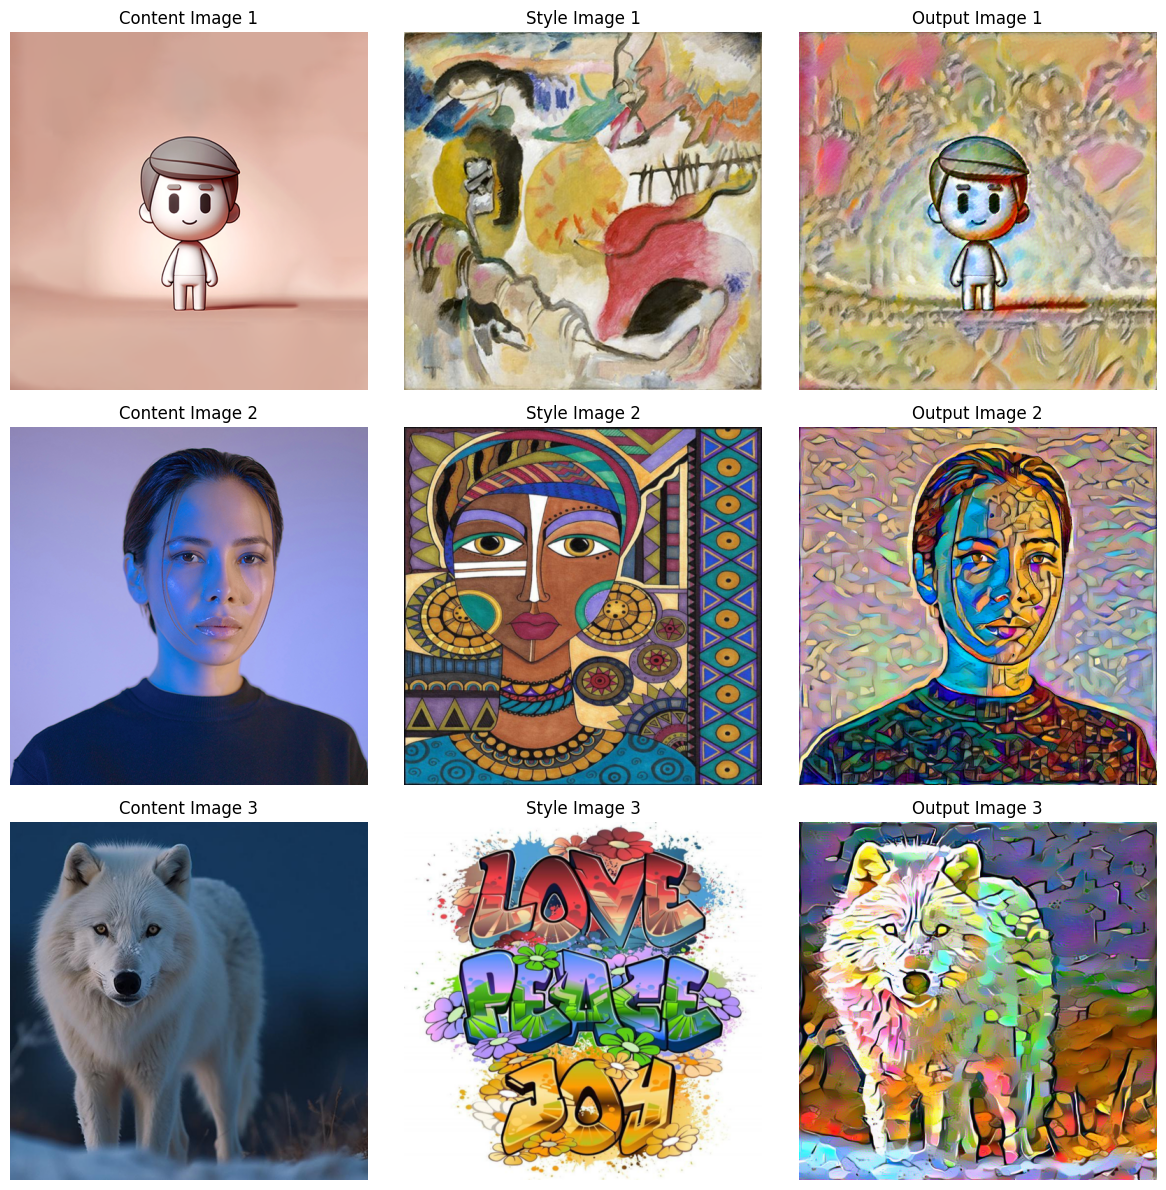

In [22]:
# 학습 실행 및 결과 저장
output_images = []
for i in range(3):
    print(f"\n### Processing Pair {i+1} ###\n")
    input_img = content_images[i].clone() # noise image 대신 content image를 그대로 넣어줌 (noise 넣을 시 학습이 아예 안 되었음)
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_images[i], style_images[i], input_img)
    output_images.append(output)

num_pairs = len(output_images)
fig, axes = plt.subplots(num_pairs, 3, figsize=(12, 4 * num_pairs))

for i in range(num_pairs):
    # Content Image
    axes[i, 0].imshow(unloader(content_images[i].cpu().squeeze(0)))
    axes[i, 0].set_title(f'Content Image {i+1}')
    axes[i, 0].axis('off')

    # Style Image
    axes[i, 1].imshow(unloader(style_images[i].cpu().squeeze(0)))
    axes[i, 1].set_title(f'Style Image {i+1}')
    axes[i, 1].axis('off')

    # Output Image
    axes[i, 2].imshow(unloader(output_images[i].cpu().squeeze(0)))
    axes[i, 2].set_title(f'Output Image {i+1}')
    axes[i, 2].axis('off')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

## **분석 및 고찰**

### **Style Transfer**
- style loss는 여러 계층에서 스타일 패턴이 다르게 나와 여러 번 계산하는 것이 유리하나, content loss는 중간 계층에서 한 번만 loss를 계산해도 style transfer의 목표를 달성하는데 충분하다고 생각했습니다.
- 매 계층에서 content loss를 계산하면 출력 이미지가 콘텐츠 구조를 과하게 유지하려고 하여 스타일 변환이 어려울 것입니다.

### **학습 및 평가**
- input_img로 노이즈 이미지를 넣어보았으나, style과 content 모두 학습하지 못했습니다.
- input_img로 content image를 복사해 넣어줌으로써, 이러한 문제를 해결했습니다.
- style이 확연하지 않은 이미지에 대해서는 올바르게 style을 학습하지 못하는 결과를 초래했습니다.
- style이 확연히 두드러진 이미지를 선택함으로써 이러한 문제를 해결했습니다.